In [56]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [57]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [58]:
NUM_CLASSES = 4

# 学習データ読み込み

In [59]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [60]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [63]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 4)                 44        
                                                                 
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [64]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [65]:
# モデルコンパイル
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [66]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/3 [=========>....................] - ETA: 1s - loss: 1.5044 - accuracy: 0.1172
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 1s 141ms/step - loss: 1.4993 - accuracy: 0.1311 - val_loss: 1.4874 - val_accuracy: 0.0000e+00
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.4008 - accuracy: 0.2266
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 0s 52ms/step - loss: 1.4369 - accuracy: 0.1798 - val_loss: 1.4525 - val_accuracy: 0.0000e+00
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.4149 - accuracy: 0.2031
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 0s 51ms/step - loss: 1.4169 - accuracy: 0.2060 - val_loss: 1.4130 - val_accuracy: 0.0222
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.3687 - accuracy: 0.3047
Epo

In [67]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 35ms/step - loss: 0.0260 - accuracy: 1.0000


In [68]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [69]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 80ms/step
[1.067597e-06 1.431721e-09 9.999989e-01 5.782123e-08]
2


# 混同行列

3/3 [==============================] - 0s 9ms/step


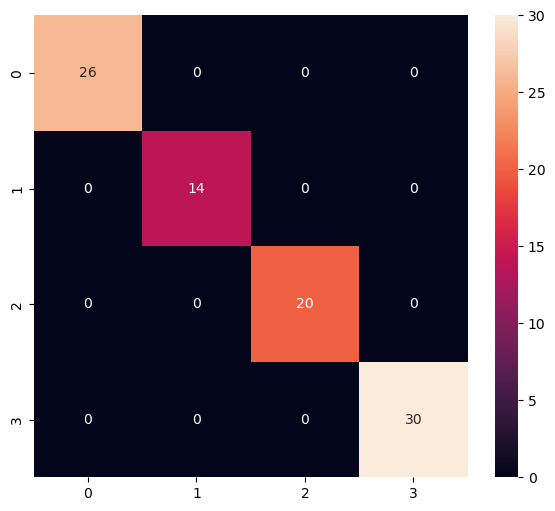

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [71]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [72]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\wille\AppData\Local\Temp\tmp6fmnn916\assets


INFO:tensorflow:Assets written to: C:\Users\wille\AppData\Local\Temp\tmp6fmnn916\assets


6596

# 推論テスト

In [73]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [74]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [75]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [76]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [77]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0675959e-06 1.4317211e-09 9.9999893e-01 5.7821229e-08]
2
